## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [2]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load normal and cancer miRNA expression data

In [3]:
from definitions import ROOT_DIR

# Load files into pandas data frames
mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

# Print data frame shapes
print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape

# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
mirna_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
mirna_normal['pathologic_stage'] = 'normal'
mirna_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}
mirna_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

# Store list of all miRNA's in miRNA expression data
mirna_list = list(mirna_tumor.columns)[2:]

# Print quick overview of data
print mirna_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print mirna_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## Load normal & cancer Gene Expression data

In [4]:
gene_exp_tumor_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/tumor/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')
gene_exp_normal_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/normal/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')

gene_exp_tumor_df.rename(columns=lambda x: x[:12], inplace=True)
gene_exp_normal_df.rename(columns=lambda x: x[:12], inplace=True)

print gene_exp_tumor_df.shape
print gene_exp_normal_df.shape

(20530, 517)
(20530, 61)


## Reshape gene expression data frames to have shape (patients x gene expression) 

In [5]:
# Remove entries with unknown Gene Symbol
gene_exp_tumor_df = gene_exp_tumor_df[gene_exp_tumor_df.GeneSymbol != '?']
gene_exp_normal_df = gene_exp_normal_df[gene_exp_normal_df.GeneSymbol != '?']

# Get list of all gene_symbols
gene_symbols = list(gene_exp_tumor_df['GeneSymbol'])
# Get list of tumor and normal patient_barcode
gene_exp_tumor_patient_barcodes = list(gene_exp_tumor_df.columns)[2:]
gene_exp_normal_patient_barcodes = list(gene_exp_normal_df.columns)[2:]

# Drop EntrezID column
gene_exp_tumor = gene_exp_tumor_df.drop(['EntrezID', 'GeneSymbol'], axis=1)
gene_exp_normal = gene_exp_normal_df.drop(['EntrezID', 'GeneSymbol'], axis=1)

# Reshaping data frame to have columns for GeneSymbols, and rows of patients
gene_exp_tumor = gene_exp_tumor.T
gene_exp_normal = gene_exp_normal.T
gene_exp_tumor.columns = gene_symbols
gene_exp_normal.columns = gene_symbols

# Add column for patients barcode
gene_exp_tumor['patient_barcode'] = gene_exp_tumor.index
gene_exp_normal['patient_barcode'] = gene_exp_normal.index

print "gene_symbols", len(gene_symbols)
print "gene_exp_tumor_patients", len(gene_exp_tumor_patient_barcodes)
print "gene_exp_normal_patients", len(gene_exp_normal_patient_barcodes)

print gene_exp_tumor.shape
print gene_exp_normal.shape

gene_symbols 20502
gene_exp_tumor_patients 515
gene_exp_normal_patients 59
(515, 20503)
(59, 20503)


## Filter samples with matched Gene Expression data and miRNA data
## More data preprocessing

In [6]:
# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
merged_tumor_patients = pandas.merge(gene_exp_tumor[['patient_barcode']], mirna_tumor, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]
merged_normal_patients = pandas.merge(gene_exp_normal[['patient_barcode']], mirna_normal, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]

# Print quick overview of data
print merged_tumor_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)
print merged_normal_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)

# Drop NA
merged_tumor_patients.dropna(inplace=True)
merged_normal_patients.dropna(inplace=True)

# Filter samples
mirna_tumor = mirna_tumor[mirna_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
mirna_normal = mirna_normal[mirna_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]
gene_exp_normal = gene_exp_normal[gene_exp_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]

# Create label vector
Y = pandas.concat([mirna_tumor, mirna_normal])['pathologic_stage']
Y.replace({'pathologic_stage': {'Stage I': 'tumor', 'Stage II': 'tumor', 'Stage III': 'tumor', 'Stage IV': 'tumor'}}, inplace=True)
n_tumor = mirna_tumor.shape[0]
n_normal = mirna_normal.shape[0]

# Drop categorical columns
mirna_tumor.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_tumor.drop(['patient_barcode'], 1, inplace=True)
mirna_normal.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_normal.drop(['patient_barcode'], 1, inplace=True)

# Drop duplicate columns names (Gene symbols with same name)
_, i = np.unique(gene_exp_tumor.columns, return_index=True)
gene_exp_tumor = gene_exp_tumor.iloc[:, i]
gene_exp_normal = gene_exp_normal.iloc[:, i]

print "mirna_tumor", mirna_tumor.shape, 'nulls:', mirna_tumor.isnull().sum().sum()
print "gene_exp_tumor", gene_exp_tumor.shape, 'nulls:', gene_exp_tumor.isnull().sum().sum()
print "mirna_normal", mirna_normal.shape, 'nulls:', mirna_normal.isnull().sum().sum()
print "gene_exp_normal", gene_exp_normal.shape, 'nulls:', gene_exp_normal.isnull().sum().sum()

NaN            7
Stage I      275
Stage II     120
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64
normal    20
Name: pathologic_stage, dtype: int64


mirna_tumor (503, 1881) nulls: 0
gene_exp_tumor (503, 20484) nulls: 0
mirna_normal (20, 1881) nulls: 0
gene_exp_normal (20, 20484) nulls: 0


## Univariate feature selection via FDR

In [7]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
# mirna_filter = SelectFdr(f_classif, alpha=0.01)
# mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
# mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
# mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

NameError: name 'mirna_new' is not defined

## Loading TargetScan database for predicted miRNA-targets interactions

In [7]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(mirna_list) & targetScan_df['Gene Symbol'].isin(gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs

In [8]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(dys_threshold=0.6)
network.train(miRNAs_tumor=mirna_tumor, targets_tumor=gene_exp_tumor,
              miRNAs_normal=mirna_normal, targets_normal=gene_exp_normal,
              putative_assocs=targetScan_df)
# print nx.bipartite.sets(network.B)

n_A 503
n_B 20


src/models/miRNA_target_network.py:48: RuntimeWarning: invalid value encountered in double_scalars
  ((n_B - 1) * np.std(miRNAs_normal[m]) * np.std(targets_normal[t]))


src/models/miRNA_target_network.py:44: RuntimeWarning: invalid value encountered in double_scalars
  ((n_A - 1) * np.std(miRNAs_tumor[m]) * np.std(targets_tumor[t]))


1881
20484
edges 2301


/opt/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/opt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0

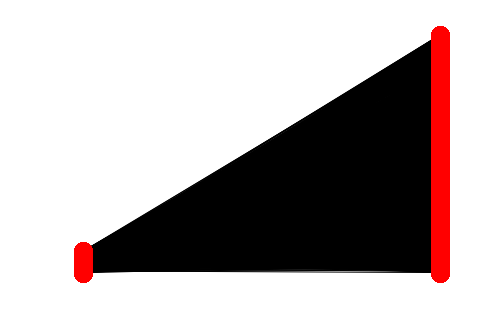

In [9]:
# miRNAs_nodes, targets_nodes = nx.bipartite.sets(network.B)
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite']==0)
targets_nodes = set(network.B) - miRNAs_nodes
print miRNAs_nodes.__len__()
print targets_nodes.__len__()

edges = network.B.edges()
miRNAs_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)[1]
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)[1]

print "edges", len(edges)
# print "miRNAs_nodes_degrees", miRNAs_nodes_degrees
# print "targets_nodes_degrees", targets_nodes_degrees

pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(miRNAs_nodes))  # put nodes from X at x=1
pos.update((n, (2, i)) for i, n in enumerate(targets_nodes))  # put nodes from Y at x=2
nx.draw(network.B, pos=pos)
plt.figure(figsize=(10, 100))
plt.show()

## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target

In [10]:
from collections import OrderedDict
print len(miRNAs_nodes_degrees)
print len(targets_nodes_degrees)

import operator
sorted_miRNAs_nodes_degrees = sorted(miRNAs_nodes_degrees.items(), key=operator.itemgetter(1), reverse=False)
sorted_targets_nodes_degrees = sorted(targets_nodes_degrees.items(), key=operator.itemgetter(1), reverse=False)

mirna_groups = OrderedDict((miRNA, -1) for miRNA in mirna_list)

group_number = 1
# For every target, find its neighbor miRNA's, which forms a group.
# The miRNA's in a groups are then assigned a corresponding number
for (target, n_neighbors) in sorted_targets_nodes_degrees:
    if n_neighbors > 1:
        miRNA_group = network.B.neighbors(target)
        for miRNA in miRNA_group:
            mirna_groups[miRNA] = group_number
        group_number += 1

groups_unique = np.unique(mirna_groups.values())
group_number = 1

# Ensure the rest of the miRNAs not in groups to have unique group number, starting from 1
for miRNA, group_assg in mirna_groups.iteritems():
    if group_assg == -1:
        while group_number in groups_unique:
            group_number += 1
        mirna_groups[miRNA] = group_number
        group_number += 1
    
print mirna_groups.values()
# print group_number

# print map(network.B.neighbors, network.B.neighbors(sorted_miRNAs_nodes_degrees[0][0]))

1881
20484
[1, 2, 3, 426, 426, 426, 237, 4, 5, 412, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 422, 385, 428, 406, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 420, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 42, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 409, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 407, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 430, 355, 166, 167, 168, 169, 170, 171, 172, 394, 173, 174, 175, 176, 405, 18, 380, 178, 179, 406, 180, 414, 428, 181, 427, 313, 182, 183, 407, 184, 185, 187, 188, 189, 190, 424, 409, 324, 191, 192, 424, 193, 194, 195, 196, 197, 198, 62, 199, 430, 130, 200, 2

In [11]:
pathologic_stage_map = {'normal': -1,'Stage I': 1, 'Stage IA': 1, 'Stage IB': 1,
                        'Stage II': 1, 'Stage IIA': 1, 'Stage IIB': 1,
                        'Stage III': 1, 'Stage IIIA': 1, 'Stage IIIB': 1,
                        'Stage IV': 1}
y = Y.replace(pathologic_stage_map)
y

0      1
1      1
2      1
3      1
4      1
5      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
30     1
      ..
502    1
503    1
505    1
506    1
507    1
508    1
509    1
510    1
511    1
512    1
0     -1
3     -1
6     -1
8     -1
9     -1
13    -1
14    -1
16    -1
21    -1
22    -1
23    -1
27    -1
30    -1
32    -1
34    -1
35    -1
38    -1
39    -1
40    -1
41    -1
Name: pathologic_stage, dtype: int64

## Run Group LASSO

In [61]:
from src.models.GroupLasso import group_lasso
import spams
# coefs = group_lasso(pandas.concat([mirna_tumor, mirna_normal]), Y, alpha=0.5, groups=np.array(mirna_groups.values()), max_iter=100)
# pandas.concat([mirna_tumor, mirna_normal]).shape
# Y.shape
# np.array(mirna_groups.values()).shape

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'lambda1': 0.05, 'it0': 10, 'max_it': 500,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}

X = np.asanyarray(pandas.concat([mirna_tumor, mirna_normal]), dtype=myfloat)
X = spams.normalize(X)
y = np.array(y, dtype=myfloat)
y = np.reshape(y, [y.shape[0], 1])
W0 = np.zeros((X.shape[1], y.shape[1]), dtype=myfloat, order="F")

print type(X), X.shape
print type(y), y.shape
print type(W0), W0.shape

print '\nMulti-logistic + Group Lasso L2 with variable size of groups'
param['loss'] = 'weighted-logistic'
param['regul'] = 'group-lasso-l2'
param2 = param.copy()
param2['groups'] = np.array(mirna_groups.values(), dtype=np.int32)
# param2['groups'] = np.array(np.arange(1881)+1, dtype=np.int32)
param2['lambda1'] = 0.01
print param2
W, optim_info = spams.fistaFlat(y, X, W0, True, **param2)

<type 'numpy.ndarray'> (523, 1881)
<type 'numpy.ndarray'> (523, 1)
<type 'numpy.ndarray'> (1881, 1)

Multi-logistic + Group Lasso L2 with variable size of groups
{'groups': array([   1,    2,    3, ...,  429, 1801, 1802], dtype=int32), 'loss': 'weighted-logistic', 'regul': 'group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 500, 'pos': False, 'intercept': False, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.01, 'it0': 10}


In [62]:
print 'non-zero', len(W.nonzero()[0])
print 'loss', np.sqrt(np.sum(np.square(np.dot(X, W) - y)))
print [(mirna_list[i], W[i]) for i in W.nonzero()[0]]

non-zero 29
loss 32.5259167415
[('hsa-let-7b', array([-2.85801005])), ('hsa-let-7c', array([-4.15097564])), ('hsa-let-7d', array([-4.43714661])), ('hsa-mir-130a', array([ 4.30781942])), ('hsa-mir-133b', array([-1.86054289])), ('hsa-mir-143', array([-7.35699753])), ('hsa-mir-144', array([-3.50174513])), ('hsa-mir-15a', array([ 5.83918782])), ('hsa-mir-182', array([ 8.97865781])), ('hsa-mir-20a', array([ 1.29759129])), ('hsa-mir-20b', array([ 0.52202859])), ('hsa-mir-21', array([ 11.96702164])), ('hsa-mir-222', array([ 1.23359424])), ('hsa-mir-23a', array([ 3.26879656])), ('hsa-mir-2681', array([-0.00026513])), ('hsa-mir-26b', array([ 0.66500432])), ('hsa-mir-27a', array([ 3.67367661])), ('hsa-mir-301a', array([ 5.2468422])), ('hsa-mir-30b', array([ 1.55551959])), ('hsa-mir-32', array([ 2.05013425])), ('hsa-mir-372', array([ 0.20475158])), ('hsa-mir-422a', array([-0.0005757])), ('hsa-mir-4529', array([-2.21025485])), ('hsa-mir-454', array([ 6.48633642])), ('hsa-mir-505', array([-0.219978

In [56]:
print 'non-zero', len(W.nonzero()[0])
print 'loss', np.sqrt(np.sum(np.square(np.dot(X, W) - y)))
print [(mirna_list[i], W[i]) for i in W.nonzero()[0]]

non-zero 16
loss 88.2261185107
[('hsa-mir-10a', array([ 0.00100229])), ('hsa-mir-130a', array([ 5.56136891])), ('hsa-mir-15a', array([ 8.85844108])), ('hsa-mir-182', array([ 20.92991451])), ('hsa-mir-20a', array([ 0.00302463])), ('hsa-mir-20b', array([ 0.00081239])), ('hsa-mir-21', array([ 33.68589129])), ('hsa-mir-27a', array([ 1.62334161])), ('hsa-mir-301a', array([ 11.51897146])), ('hsa-mir-301b', array([ 0.00093449])), ('hsa-mir-372', array([ 0.00087512])), ('hsa-mir-425', array([ 0.00137275])), ('hsa-mir-454', array([ 11.16583146])), ('hsa-mir-590', array([ 14.86128546])), ('hsa-mir-93', array([ 0.00207631])), ('hsa-mir-96', array([ 14.41086729]))]


## Loading DIANA-TarBase database for experimentally validated miRNA-targets interactions

In [53]:
# Load data frame from file
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)

# # Select only homo sapiens miRNA-target pairs
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]

lung_neoplasm_miRNAs = HMDD_df[1].unique()
lung_neoplasm_miRNAs

array(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g', 'hsa-let-7i', 'hsa-mir-101-1',
       'hsa-mir-106a', 'hsa-mir-124-1', 'hsa-mir-124-2', 'hsa-mir-124-3',
       'hsa-mir-125a', 'hsa-mir-125b-1', 'hsa-mir-126', 'hsa-mir-128-2',
       'hsa-mir-132', 'hsa-mir-140', 'hsa-mir-143', 'hsa-mir-145',
       'hsa-mir-146a', 'hsa-mir-146b', 'hsa-mir-150', 'hsa-mir-155',
       'hsa-mir-17', 'hsa-mir-181c', 'hsa-mir-183', 'hsa-mir-18a',
       'hsa-mir-191', 'hsa-mir-192', 'hsa-mir-197', 'hsa-mir-198',
       'hsa-mir-199a-1', 'hsa-mir-199b', 'hsa-mir-19a', 'hsa-mir-19b-1',
       'hsa-mir-203', 'hsa-mir-205', 'hsa-mir-20a', 'hsa-mir-21',
       'hsa-mir-210', 'hsa-mir-212', 'hsa-mir-214', 'hsa-mir-216a',
       'hsa-mir-216b', 'hsa-mir-218-2', 'hsa-mir-219-1', 'hsa-mir-223',
       'hsa-mir-224', 'hsa-mir-24-2', 'hsa-mir-26a-1', 'hsa-mir-27b',
       'hsa-mir-29a', 'hsa-mir-2

In [153]:
len(mirna_list)

1881

In [212]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

SPPL3 hsa-mir-369


[autoreload of _pytest.assertion failed: Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name util
]
[autoreload of py.test.cmdline failed: Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named cmdline
]


NameError: name 'miRecords_df' is not defined

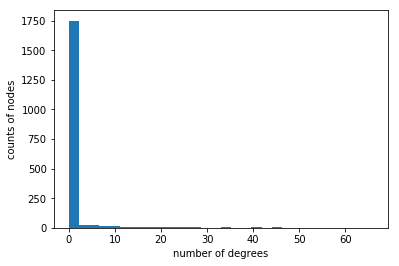

In [114]:
# plt.hist(miRNAs_nodes_degrees[1].values())
plt.hist(targets_nodes_degrees[0].values(), bins=30)
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 22,
 1,
 0,
 0,
 22,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 4,
 16,
 17,
 0,
 0,
 0,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 48,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 7,
 1,
 3,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 37,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 1,
 19,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,